In [1]:
from ase.db import connect
import numpy as np
import pandas as pd
from typing import List, Union, Optional
from ase.atoms import Atoms
import matplotlib.pyplot as plt

In [10]:
def combine_multiple_dbs(target_db_path, *source_db_paths):
    # Connect to the target database
    target_db = connect(target_db_path, append=True)  # Open in append mode

    # Iterate over each source database
    for source_db_path in source_db_paths:
        # Connect to the current source database
        source_db = connect(source_db_path)
        
        # Iterate over rows in the source database and append them to the target database
        for row in source_db.select():
            target_db.write(row.toatoms(), data=row.data)

        print(f"Entries from {source_db_path} have been appended to {target_db_path}.")


In [11]:
combine_multiple_dbs("db10_final.db", "./db9_final_higher_forces.db", './db10_calculated.db')

Entries from ./db9_final_higher_forces.db have been appended to db10_final.db.
Entries from ./db10_calculated.db have been appended to db10_final.db.


In [8]:

class ACEDataProcessor:
    def __init__(self, db_path: str, specorder: List[str], energy_correction: List[float],
                 energy_name: str = "free_energy", force_name: str = "forces"):
        self.db_path = db_path
        self.specorder = specorder
        self.energy_correction = energy_correction
        self.energy_name = energy_name
        self.force_name = force_name
        self.db = connect(self.db_path)
        self.df = None

    def load_data(self, max_force: float = None):
        """
        Loads data from the database, optionally filtering by maximum force.

        Args:
            max_force (float): Maximum force allowed (eV/Angstrom). If None, no filtering is applied.
        """
        data = {
            "ase_atoms": [],
            "forces": [],
            "energy_corrected": [],
            "energy": []
        }

        for row in self.db.select():
            try:
                if max_force is None or row.fmax < max_force:
                    atoms = row.toatoms()
                    forces = self._get_forces(atoms)
                    energy = self._get_energy(atoms)

                    data["forces"].append(forces)
                    data["energy"].append(energy)
                    data["ase_atoms"].append(atoms)

                    symbols = atoms.get_chemical_symbols()
                    data["energy_corrected"].append(self._calculate_corrected_energy(energy, symbols))
            except Exception as e:
                print(f"Error processing row {row.id}: {e}")

        self.df = pd.DataFrame(data)

    def _get_forces(self, atoms: Atoms):
        """
        Retrieves forces from the Atoms object.

        Args:
            atoms (Atoms): ASE Atoms object.

        Returns:
            np.ndarray: Forces array.
        """
        if self.force_name == "forces":
            return atoms.arrays.get("forces", atoms.get_forces())
        else:
            return atoms.arrays[self.force_name]

    def _get_energy(self, atoms: Atoms):
        """
        Retrieves energy from the Atoms object.

        Args:
            atoms (Atoms): ASE Atoms object.

        Returns:
            float: Energy value.
        """
        if self.energy_name == "energy":
            return atoms.info.get("energy", atoms.get_potential_energy())
        elif self.energy_name == "free_energy":
            return atoms.info.get("free_energy", atoms.get_potential_energy(force_consistent=True))
        else:
            return atoms.info[self.energy_name]

    def _calculate_corrected_energy(self, energy: float, symbols: List[str]):
        """
        Calculates the corrected energy based on the provided energy correction values.

        Args:
            energy (float): Uncorrected energy.
            symbols (List[str]): List of atomic symbols.

        Returns:
            float: Corrected energy.
        """
        correction = sum(num * self.energy_correction[i] for i, num in enumerate(symbols.count(spec) for spec in self.specorder))
        return energy - correction

    def save_to_pickle(self, filename: str):
        """
        Saves the processed data to a pickle file.

        Args:
            filename (str): Filename for the pickle file.
        """
        self.df.to_pickle(filename, compression="gzip", protocol=4)

    def load_from_pickle(self, filename: str):
        """
        Loads data from a pickle file.

        Args:
            filename (str): Filename of the pickle file.
        """
        self.df = pd.read_pickle(filename, compression="gzip")

    def analyze_data(self):
        """
        Performs analysis on the loaded data.

        This is a placeholder method, you should implement your desired analysis here.
        """
        if self.df is None:
            print("Data not loaded. Please call load_data() or load_from_pickle() first.")
            return

        # Example analysis: print basic statistics
        print("Number of structures:", len(self.df))
        print("Mean energy:", self.df["energy"].mean())
        print("Mean corrected energy:", self.df["energy_corrected"].mean())
        
        # Read the dataset
        energies = []
        energies_per_atom = []
        volume = []
        volume_per_atom = []
        forces_norm = []
        natoms = []

        for row in self.db.select():
            try:
                atoms = row.toatoms()
                energies.append(atoms.get_potential_energy())
                energies_per_atom.append(atoms.get_potential_energy() / len(atoms))
                volume.append(atoms.get_volume())
                volume_per_atom.append(atoms.get_volume() / len(atoms))
                forces_norm.append(np.linalg.norm(atoms.get_forces(), axis=1))
                natoms.append(len(atoms))
            except Exception as e:
                print(f"Error in row {row.id}: {e}")

        # Create numpy arrays
        energies = np.array(energies)
        energies_per_atom = np.array(energies_per_atom)
        volume = np.array(volume)
        volume_per_atom = np.array(volume_per_atom)
        forces_norm = np.concatenate(forces_norm)
        natoms = np.array(natoms)

        # Plot on a single figure
        fig, ax = plt.subplots(3, 2, figsize=(10, 10))

        # Plot energy vs. volume scatter
        ax[0, 0].scatter(volume_per_atom, energies_per_atom, alpha=0.7, color="blue")
        ax[0, 0].set_xlabel(r"Volume ($\AA^3$)")
        ax[0, 0].set_ylabel(r"Energy (eV)")
        ax[0, 0].set_title("Energy vs. Volume")

        # Plot energies per atom histogram
        ax[0, 1].hist(energies_per_atom, bins=50, color="green", alpha=0.7)
        ax[0, 1].set_xlabel(r"Energy per Atom (eV/atom)")
        ax[0, 1].set_ylabel(r"Count")
        ax[0, 1].set_title("Energy per Atom Distribution")

        # plot volume per atom histogram
        ax[1, 0].hist(volume_per_atom, bins=50, color="red", alpha=0.7)
        ax[1, 0].set_xlabel(r"Volume per Atom ($\AA^3$/atom)")
        ax[1, 0].set_ylabel(r"Count")
        ax[1, 0].set_title("Volume per Atom Distribution")

        # Plot forces histogram
        ax[1, 1].hist(forces_norm, bins=200, color="purple", alpha=0.7)
        ax[1, 1].set_xlabel(r"Force Norm (eV/$\AA$)")
        ax[1, 1].set_ylabel(r"Count")
        ax[1, 1].set_title("Force Norm Distribution")

        # Plot number of atoms histogram
        ax[2, 0].hist(
            natoms,
            bins=50,
            align="left",
            rwidth=0.8,
            color="brown",
            alpha=0.7,
        )
        ax[2, 0].set_xlabel(r"Number of Atoms")
        ax[2, 0].set_ylabel(r"Count")
        ax[2, 0].set_title("Number of Atoms Distribution")

        plt.tight_layout()
        plt.savefig("db_analysis.png", dpi=300)



Error processing row 7223: 'AtomsRow' object has no attribute 'forces'
Error processing row 7224: 'AtomsRow' object has no attribute 'forces'
Error processing row 7225: 'AtomsRow' object has no attribute 'forces'
Error processing row 7226: 'AtomsRow' object has no attribute 'forces'
Error processing row 7227: 'AtomsRow' object has no attribute 'forces'
Error processing row 7228: 'AtomsRow' object has no attribute 'forces'
Error processing row 7229: 'AtomsRow' object has no attribute 'forces'
Error processing row 7230: 'AtomsRow' object has no attribute 'forces'
Error processing row 7231: 'AtomsRow' object has no attribute 'forces'
Error processing row 7232: 'AtomsRow' object has no attribute 'forces'
Error processing row 7233: 'AtomsRow' object has no attribute 'forces'
Error processing row 7234: 'AtomsRow' object has no attribute 'forces'
Error processing row 7235: 'AtomsRow' object has no attribute 'forces'
Error processing row 7236: 'AtomsRow' object has no attribute 'forces'
Error 

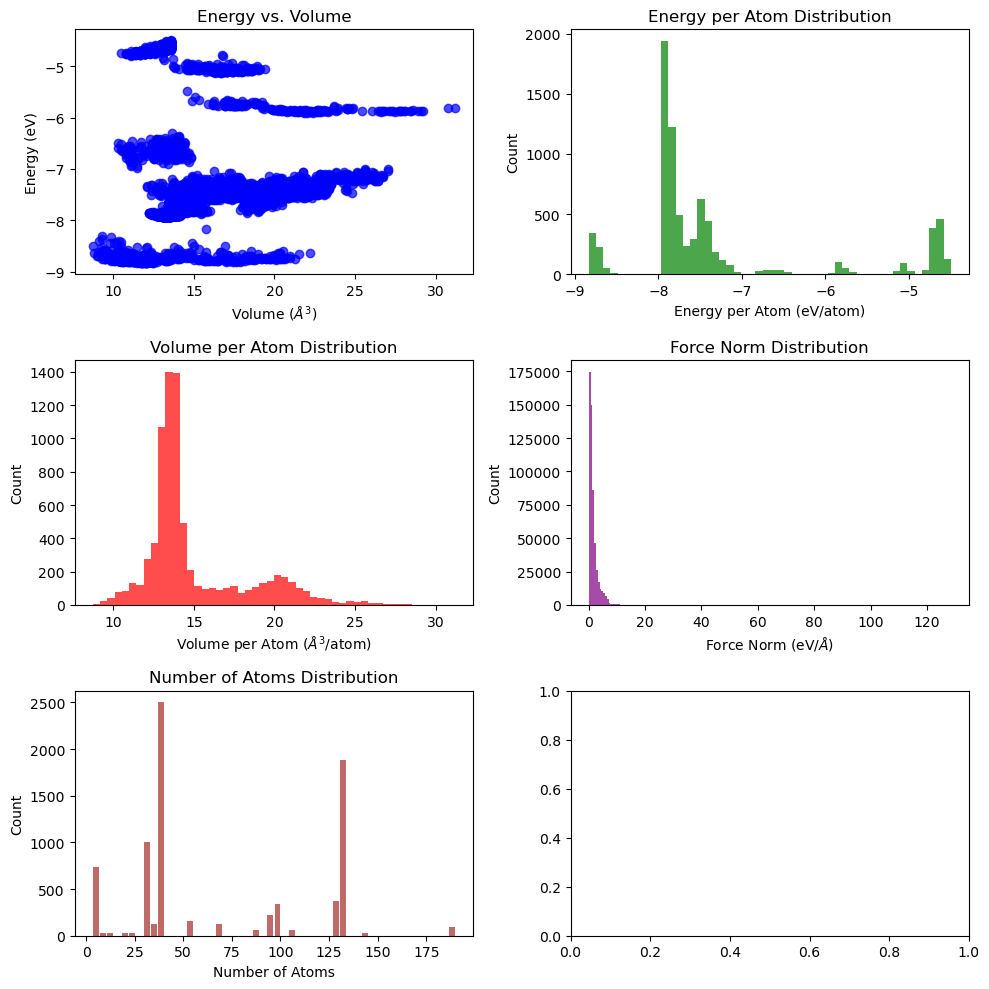

In [9]:
# Example usage:
processor = ACEDataProcessor(db_path="db10_final.db", 
                             specorder=["Ba", "O", "Ti"], 
                             energy_correction=[0.0, 0.0, 0.0])

# Load data with a maximum force filter of 10 eV/Angstrom
processor.load_data(max_force=100)

# Save processed data to a pickle file
processor.save_to_pickle("db10_final.pkl.gz")

# Load data from the pickle file
processor.load_from_pickle("db10_final.pkl.gz")

# Perform analysis
processor.analyze_data()